In [ ]:
""" 
Predicción de Salarios en Data Science - Evaluación del Modelo

En este notebook, vamos a cargar el modelo entrenado en Pipelines_I.ipynb, 
haremos predicciones sobre nuevos datos y evaluar su rendimiento.

Objetivos:
- Cargar el modelo de Machine Learning previamente entrenado.
- Cargar y limpiar los datos de prueba para asegurarnos de que tienen el mismo formato que los de entrenamiento.
- Aplicar la misma transformación de datos que usamos en el entrenamiento.
- Usar el modelo para predecir los salarios en USD.
- Evaluar qué tan buenas son las predicciones con métricas como MSE y R².
- Guardar las predicciones en un archivo CSV.

"""

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from joblib import load
""" 
1. Cargar el modelo entrenado

Antes de hacer predicciones, necesitamos cargar el modelo que entrenamos en Pipelines_I.ipynb.
Este modelo ya sabe cómo transformar los datos y hacer predicciones.

"""
sys.path.append(os.path.abspath('..'))  

""" 
2. Cargar y limpiar los datos de prueba

Ahora cargamos los datos de prueba (datos que el modelo no ha visto antes) 
para ver qué tan bien predice los salarios.

Aplicamos las mismas funciones de limpieza usadas en Pipelines_I.ipynb
para asegurarnos de que los datos están en el mismo formato

"""
# Importamos funciones propias de limpieza de datos
from FUNCIONES.Funciones_limpieza import load_data, clean_data

# Cargar el modelo entrenado
model_path = "../models/pipeline_model.pkl"
print(f"Cargando modelo desde {model_path}...")
model = load(model_path)
print("Modelo cargado correctamente.")

# Cargar datos de prueba
df_test = load_data("ds_salaries_test.csv")
df_test_clean = clean_data(df_test)
print("Datos de prueba cargados y limpiados.")

""" 
3. Aplicar la transformación logarítmica a los salarios

En el entrenamiento aplicamos np.log1p() para reducir la variabilidad de los salarios.
Aquí hacemos lo mismo en los datos de prueba para que coincidan con lo que vio el modelo.

"""
df_test_clean['salary_in_usd'] = np.log1p(df_test_clean['salary_in_usd'])

""" 
4. Asegurar que las categorías sean consistentes

El modelo solo conoce las 10 categorías más comunes en job_title y company_location,
así que las categorías menos frecuentes las agrupamos bajo "Other".
Esto evita errores cuando el modelo encuentra categorías desconocidas.


"""
top_jobs = df_test_clean['job_title'].value_counts().index[:10]
df_test_clean['job_title'] = df_test_clean['job_title'].apply(lambda x: x if x in top_jobs else 'Other')

top_locations = df_test_clean['company_location'].value_counts().index[:10]
df_test_clean['company_location'] = df_test_clean['company_location'].apply(lambda x: x if x in top_locations else 'Other')

""" 
5. Definir las variables de entrada (X) y salida (y)

El modelo necesita las mismas variables que usamos en el entrenamiento.

"""
X_test = df_test_clean[['work_year', 'experience_level', 'job_title', 'company_location', 'company_size']]
y_test = df_test_clean['salary_in_usd']

# Verificar que las columnas de X_test coincidan con las de entrenamiento
print("Columnas de X_test:", X_test.columns)

""" 
6. Hacer predicciones con el modelo

Para predecir, primero aplicamos la transformación a los datos de prueba 
(las mismas que usamos en el entrenamiento) y luego pasamos los datos al modelo.


"""
print("Haciendo predicciones...")
y_pred = model.predict(X_test)
print("Predicciones completadas.")

# Evaluar si la transformación logarítmica está afectando
print("Salario mínimo en y_test:", y_test.min())
print("Salario máximo en y_test:", y_test.max())


""" 
7. Evaluar el rendimiento del modelo

Para saber qué tan bien predice el modelo, usamos dos métricas:

- Mean Squared Error (MSE):Nos dice qué tan grande es el error en promedio (mientras más bajo, mejor).
- R² Score: Nos dice qué porcentaje de la variabilidad de los salarios es explicada por el modelo (mientras más cerca de 1, mejor).

"""
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Métricas del modelo:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
""" 
8. Guardar las predicciones en un archivo CSV

Para poder analizar los resultados después, guardamos las predicciones en un archivo CSV.

"""
output_path = "../RESULTADOS/predictions.csv"

# Crear el directorio si no existe
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_test_clean['salary_pred'] = y_pred
df_test_clean[['work_year', 'experience_level', 'job_title', 'company_location', 'company_size', 'salary_pred']].to_csv(output_path, index=False)

print(f"Predicciones guardadas en {output_path}")

Cargando modelo desde ../models/pipeline_model.pkl...
Modelo cargado correctamente.
✅ Archivo 'ds_salaries_test.csv' cargado correctamente. Dimensiones: (517, 11)
🔹 Se han eliminado duplicados. Dimensiones actuales: (517, 11)
🔹 Se han eliminado valores nulos. Dimensiones actuales: (517, 11)
🔹 Los nombres de las columnas han sido normalizados.
Datos de prueba cargados y limpiados.
Columnas de X_test: Index(['work_year', 'experience_level', 'job_title', 'company_location',
       'company_size'],
      dtype='object')
Haciendo predicciones...
Predicciones completadas.
Salario mínimo en y_test: 8.596004371840527
Salario máximo en y_test: 12.973789120389844
Métricas del modelo:
Mean Squared Error (MSE): 0.2113
R² Score: 0.5247
Predicciones guardadas en ../RESULTADOS/predictions.csv


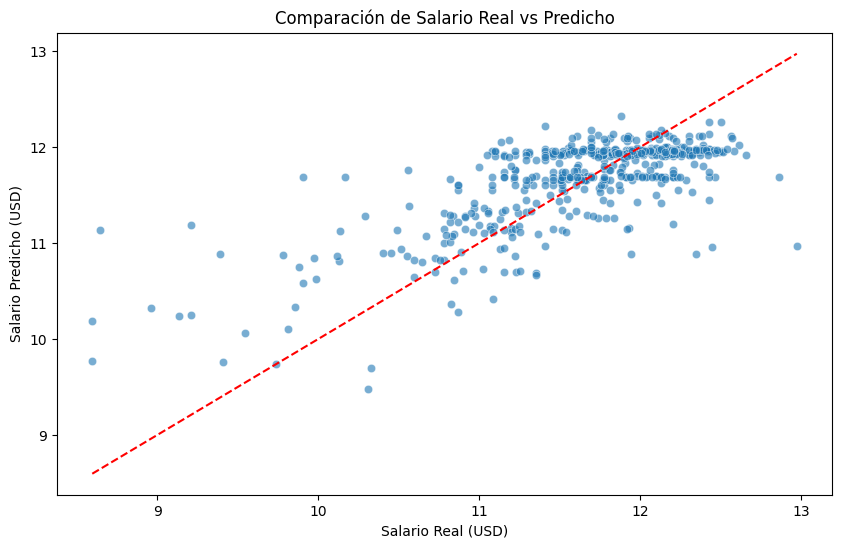

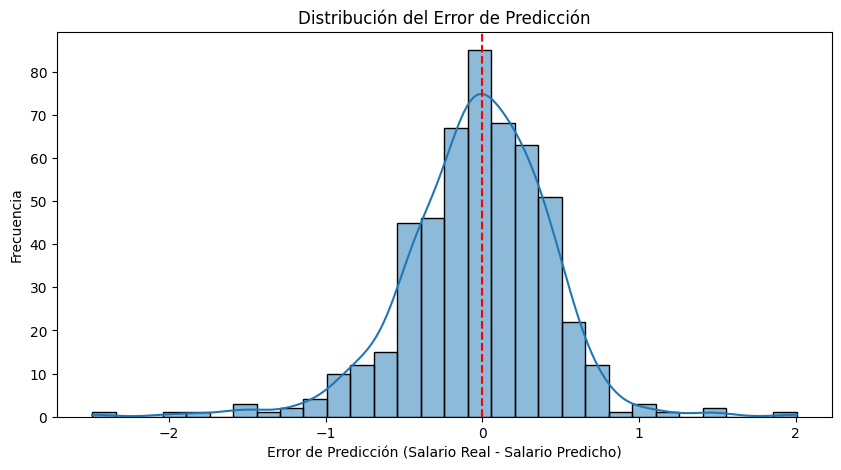

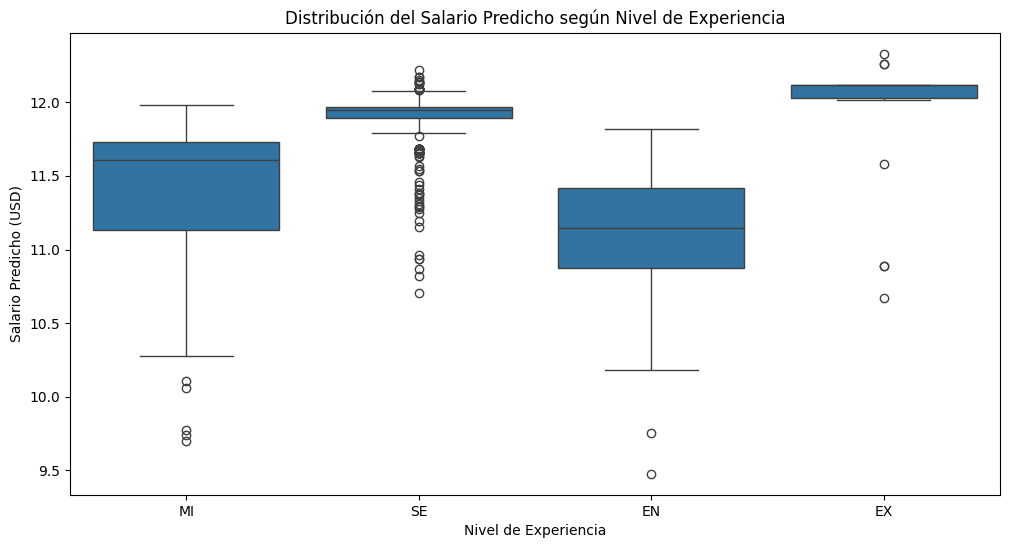

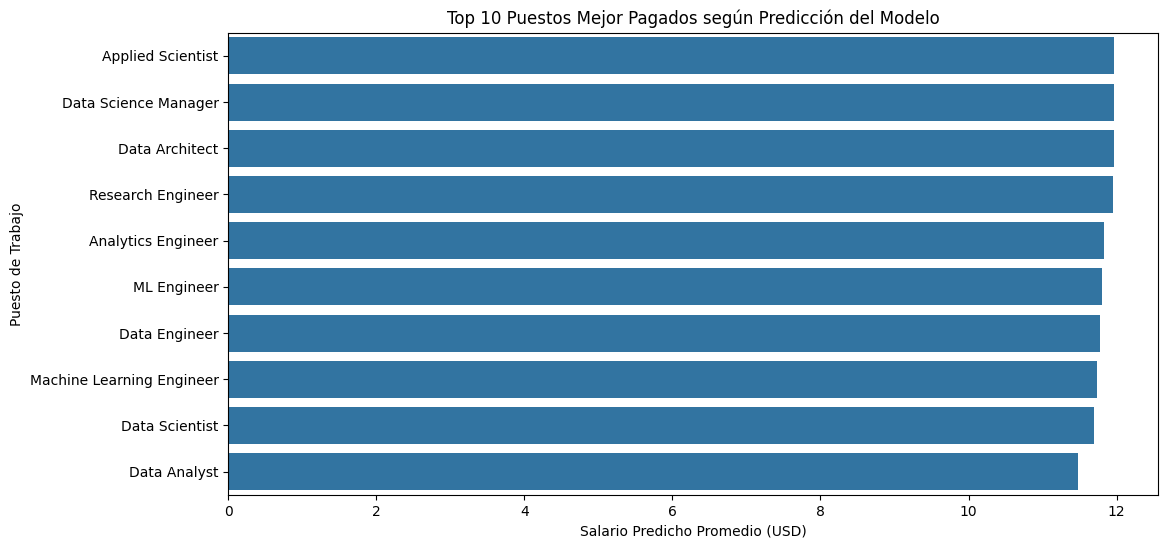

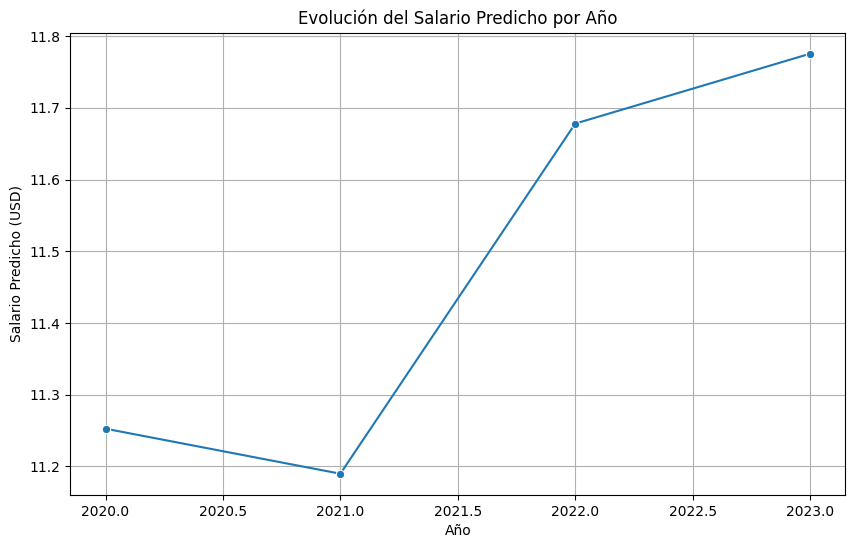

In [13]:
# 📌 Comparación entre Salario Real y Salario Predicho
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Línea de referencia
plt.xlabel("Salario Real (USD)")
plt.ylabel("Salario Predicho (USD)")
plt.title("Comparación de Salario Real vs Predicho")
plt.show()

# 📌 Distribución del Error de Predicción
errors = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Error de Predicción (Salario Real - Salario Predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Error de Predicción")
plt.show()

# 📌 Boxplot de Salarios por Nivel de Experiencia
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_test_clean['experience_level'], y=df_test_clean['salary_pred'])
plt.xlabel("Nivel de Experiencia")
plt.ylabel("Salario Predicho (USD)")
plt.title("Distribución del Salario Predicho según Nivel de Experiencia")
plt.show()

# 📌 Comparación de Salario Predicho por Puesto de Trabajo (Top 10)
plt.figure(figsize=(12, 6))
top_jobs_pred = df_test_clean.groupby('job_title')['salary_pred'].mean().sort_values(ascending=False).head(10)
sns.barplot(y=top_jobs_pred.index, x=top_jobs_pred.values)
plt.xlabel("Salario Predicho Promedio (USD)")
plt.ylabel("Puesto de Trabajo")
plt.title("Top 10 Puestos Mejor Pagados según Predicción del Modelo")
plt.show()

# 📌 Evolución del Salario Predicho por Año
plt.figure(figsize=(10, 6))
salary_pred_year = df_test_clean.groupby('work_year')['salary_pred'].mean().reset_index()
sns.lineplot(x='work_year', y='salary_pred', data=salary_pred_year, marker='o')
plt.xlabel("Año")
plt.ylabel("Salario Predicho (USD)")
plt.title("Evolución del Salario Predicho por Año")
plt.grid(True)
plt.show()


